In [100]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from skimage.draw import polygon_perimeter, polygon
from skimage.morphology import label
from skimage.morphology import medial_axis
from scipy.ndimage.measurements import center_of_mass
from skimage.draw import bezier_curve
from scipy.ndimage.morphology import binary_fill_holes
from skimage.transform import warp
from skimage.transform import SimilarityTransform

In [101]:
img1 = 255 - cv2.imread('../images/trimmed_queries_divorce/divorce/G/0_extraction_doc_12_line_23_char_46_original_trim.png', 0) 
img2 = 255 - cv2.imread('../images/trimmed_queries_divorce/queries/G/extraction_doc_13_line_7_char_17_original_trim.png', 0)
img3 = 255 - cv2.imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_5_line_35_char_49_original_trim.png', 0)

In [102]:
def intersection(ima, imb):
    img = ima.copy()
    img[np.where(ima != imb)] = 0
    return img

def union(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 255
    return img

# returns the components of ima that are not in imb
# (i.e., deletes imb from ima)
def difference(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 0
    return img

def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect

def endpoints(image, rect):
    seg_intersect = intersection(rect, image)
    labels = label(seg_intersect)
    return [np.array(np.where(labels == 1))[:,0],
           np.array(np.where(labels == 1))[:,-1],
           np.array(np.where(labels == 2))[:,0],
           np.array(np.where(labels == 2))[:,-1]]

def midpoint(endpoints, mass_center, dist_shift = 7, to_center = True):
    init_mid = (endpoints[0] + endpoints[1])/2.0
    angle = np.arctan2((mass_center - init_mid)[0], (mass_center - init_mid)[1])
    
    if not to_center:
        rot_mat = np.array([[np.cos(-angle), np.sin(-angle)], [-1*np.sin(-angle), np.cos(-angle)]])
    else:
        rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_with_rect(image, rect_outline, filled_rect, dist_shift):
    endpts = endpoints(image, rect_outline)
    imnew = image.copy()
    imnew[np.where(filled_rect > 0)] = 0
    mid1 = midpoint([endpts[0], endpts[2]], center_of_mass(image), dist_shift).astype(np.uint8)
    mid2 = midpoint([endpts[1], endpts[3]], center_of_mass(image), dist_shift).astype(np.uint8)
    
    # now draw two bezier curves that form the boundaries of the bend
    rr, cc = bezier_curve(endpts[0][0], endpts[0][1], mid1[0][0], mid1[1][0],
                         endpts[2][0], endpts[2][1], 2)
    imnew[rr, cc] = 255

    rr, cc = bezier_curve(endpts[1][0], endpts[1][1], mid2[0][0], mid2[1][0],
                         endpts[3][0], endpts[3][1], 2)
    imnew[rr, cc] = 255
    
    imnew = binary_fill_holes(imnew)
    
    return imnew
    
def bend_image(image, center=[50, 50], width=13, height=20, angle = 0, dist_shift = 7):
    rect_outline = create_rectangle(center, height, width, angle, filled = False)
    filled_rect = create_rectangle(center, height, width, angle, filled = True)
    try:
        return bend_with_rect(image, rect_outline, filled_rect, dist_shift)
    except:
        return image

def band_break_image(image, center = [45, 35], width = 30, height=8, angle = -0.9):
    filled_rect = create_rectangle(center, height, width, angle)
    return difference(image, filled_rect)

def notch_break_image(image, center=[32, 64], width = 6, height = 7, angle = 0, trapezoid = True):
    if trapezoid:
        break_shape = union(create_rectangle(center, height, width, angle),
                           create_rectangle(center, height + 2, width - 2, angle))
    else:
        break_shape = create_rectangle(center, height, width, angle)
    
    return difference(image, break_shape)

def center_image(image, new_mass_center = [34, 48]):
    curr_center = center_of_mass(image)
    tform = SimilarityTransform(translation=(int(curr_center[1] - new_mass_center[1]), 
                                             int(curr_center[0] - new_mass_center[0])))
    #tform = SimilarityTransform(translation=(0, -10))
    warped = warp(image, tform)
    warped[np.where(warped > 0)] = 255
    return warped

def remove_junk(example_img, standard_img):
    imnew = intersection(example_img, standard_img)
    junk = difference(example_img, standard_img)
    return imnew, junk

def break_image(example_img, standard_img, breaking_fun):
    imnew, junk = remove_junk(example_img, standard_img)
    defect = breaking_fun(imnew)
    return union(defect, junk)

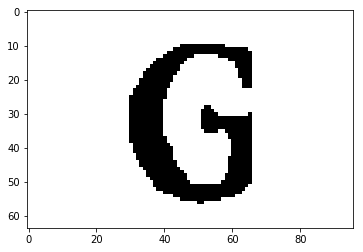

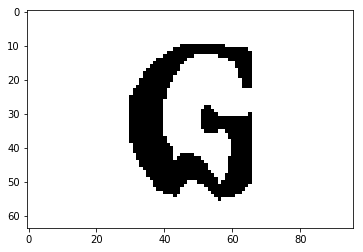

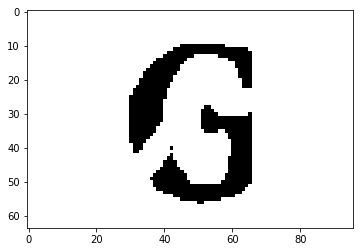

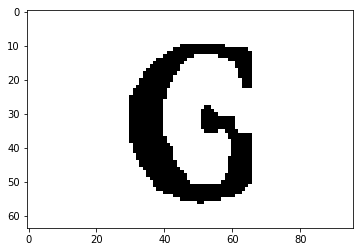

In [105]:
g_files = glob.glob('../images/trimmed_queries_divorce/divorce/G/*.png')
g_array = np.ndarray(shape=(len(g_files), 64, 96))
for ind, f in enumerate(g_files):
    g_array[ind,:,:] = center_image(255 - cv2.imread(f, 0))
    
avg_g = np.mean(g_array, axis=0)
typical_g = avg_g.copy()
typical_g[np.where(typical_g > 20)] = 255
typical_g[np.where(typical_g < 255)] = 0


img = g_array[2,:,:]
#img = 255 - cv2.imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_15_line_24_char_36_original_trim.png', 0)
#img = center_image(img)
plt.imshow(255 - img, cmap="gray")
plt.show()

defect = break_image(img, typical_g, (lambda x: bend_image(x, center = [50, 50], height=18)))
plt.imshow(255 - defect, cmap="gray")
plt.show()

defect = break_image(img, typical_g, band_break_image)
plt.imshow(255 - defect, cmap="gray")
plt.show()

defect = break_image(img, typical_g, notch_break_image)
plt.imshow(255 - defect, cmap="gray")
plt.show()

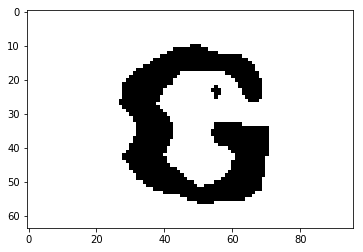

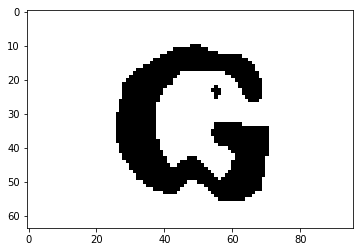

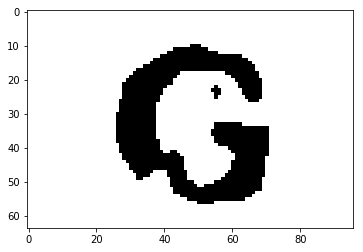

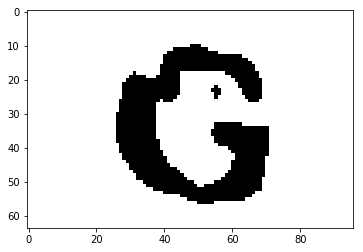

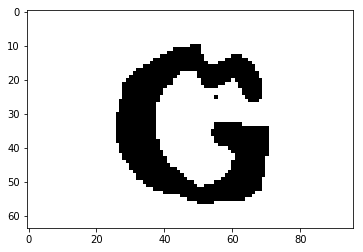

In [27]:
bent = bend_image(warped, center = [35, 35], width = 20, height = 15, angle = 0)
plt.imshow(255 - bent, cmap="gray")
plt.show()

bent = bend_image(warped, center = [50, 50], height=15)
plt.imshow(255 - bent, cmap="gray")
plt.show()

bent = bend_image(warped, center = [50, 40], width = 20, height = 10, angle = -0.8, dist_shift = 8)
plt.imshow(255 - bent, cmap="gray")
plt.show()

bent = bend_image(warped, center = [15, 35], width = 20, height = 10, angle = 0.8, dist_shift = 8)
plt.imshow(255 - bent, cmap="gray")
plt.show()

bent = bend_image(warped, center = [15, 50], width = 15, height = 20, angle = 0)
#plt.imshow(255 - bent, cmap="gray")
#plt.show()

bent = bend_image(warped, center = [15, 55], width = 10, height = 20, angle = 0)
plt.imshow(255 - bent, cmap="gray")
plt.show()